## Naomi, Parshana, Sinchana, Joanna

In [30]:
%pip install pandas numpy matplotlib scikit-learn seaborn


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

TASK 1:

#1

In [32]:
df_main = pd.read_csv("S19_All_Release_2_10_22/Data/MainTable.csv")
df_subj = pd.read_csv("S19_All_Release_2_10_22/Data/LinkTables/Subject.csv")

In [33]:
# Number of unique students - using MainTable.csv
len(df_main['SubjectID'].unique())

413

In [34]:
# Number of unique students - using LinkTables/Subject.csv
len(df_subj['SubjectID'].unique())
# Less because some people did not take the final

372

#2

In [35]:
df_early = pd.read_csv("S19_All_Release_2_10_22/early.csv")
df_late = pd.read_csv("S19_All_Release_2_10_22/late.csv")
df_all = pd.concat([df_early, df_late])
mean_attempts = df_all.groupby(['AssignmentID', 'ProblemID'])['Attempts'].mean()
mean_attempts.head()
print(f"Assignment {mean_attempts.idxmax()[0]} Problem {mean_attempts.idxmax()[1]} had the most attempts at {mean_attempts.max()}.")

Assignment 487.0 Problem 102 had the most attempts at 10.422535211267606.


#3

In [36]:
df_main = pd.read_csv("S19_All_Release_2_10_22/Data/MainTable.csv")
df_compile = df_main[df_main['EventType'] == "Compile"]
compile_errors = df_compile[df_compile['Compile.Result'] == 'Error']
grouped_compile_errors = compile_errors.groupby(['AssignmentID', 'ProblemID'])['Compile.Result'].size()
print(f"Assignment {grouped_compile_errors.idxmax()[0]} Problem {grouped_compile_errors.idxmax()[1]} had the most compile errors at {grouped_compile_errors.max()}.")

Assignment 439.0 Problem 13 had the most compile errors at 2440.


Computing the total number of compiler errors faced on each problem, and report the maximum is more meaningful because it directly answers which problems had the most compile errors from all students. This is more meaningful for knowing which problems students as a whole struggled with compiling.

TASK #2: 

Investigating the Frequency of Errors Over Time to Analyze Student Progress
We hypothesize that simple syntax-related errors like "':' expected" or "';' expected" would decrease over time as students become more familiar with the programming language's syntax.

In [44]:
messages = df_main[df_main['EventType'] == "Compile.Error"][['ServerTimestamp','AssignmentID', 'ProblemID', 'CompileMessageData']]

messages['ServerTimestamp'] = pd.to_datetime(messages['ServerTimestamp'])
messages['Date'] = messages['ServerTimestamp'].dt.date

In [45]:
messages['CompileMessageData'] = messages['CompileMessageData'].apply(
    lambda x: re.sub(r"line \d+: (error: |\[empty\])?", "", x)
)
messages

,ServerTimestamp,AssignmentID,ProblemID,CompileMessageData,Date
14,2019-02-24 04:27:49,439.0,13,illegal start of expression.,2019-02-24
15,2019-02-24 04:27:49,439.0,13,illegal start of expression.,2019-02-24
16,2019-02-24 04:27:49,439.0,13,illegal start of expression.,2019-02-24
17,2019-02-24 04:27:49,439.0,13,illegal start of expression,2019-02-24
20,2019-02-24 04:29:44,439.0,13,missing return statement,2019-02-24
...,...,...,...,...,...
201541,2019-05-05 21:37:37,502.0,48,variable r is already defined in method withou...,2019-05-05
201542,2019-05-05 21:37:37,502.0,48,cannot find symbol: variable i,2019-05-05
201549,2019-05-05 23:26:16,502.0,56,cannot find symbol: variable min,2019-05-05
201556,2019-05-05 23:36:39,502.0,64,cannot find symbol: variable array,2019-05-05


In [47]:
def categorize_error(msg):
    # Syntax Error
    if re.search(r"(illegal|cannot find symbol|character literal|illegal start of|illegal escape character|illegal character|unclosed string literal|illegal line end in character literal|invalid method declaration; return type required\.|array dimension missing|bad operand type int for unary operator '!'|bad initializer for for-loop|array required, but int found|no suitable constructor found for String\(char\)|not a statement|missing return statement|integer number too large)", msg, re.IGNORECASE):
        return "Syntax Error"
    # Type Error
    elif re.search(r"(bad operand type|dereferenced|type not allowed|unexpected type|char cannot be dereferenced|incompatible types|incomparable types|cannot be converted|bad operand types|int cannot be dereferenced|array dimension missing|incomparable types: boolean and int)", msg, re.IGNORECASE):
        return "Type Error"
    # Variable/Method not found
    elif re.search(r"(variable .+ is already defined|cannot assign a value to final variable|cannot assign a value to final variable this|cannot find symbol: method|cannot find symbol: variable|cannot find symbol: class)", msg, re.IGNORECASE):
        return "Variable/Method not found"
    # Initialization Issues
    elif re.search(r"(variable declaration not allowed here|variable .+ might not have been initialized|invalid method declaration|class expected|class .+ is already defined)", msg, re.IGNORECASE):
        return "Initialization Issues"
    # Control Flow
    elif re.search(r"(for-each not applicable to expression type|orphaned case|break outside switch or loop|unreachable statement|'else' without 'if'|reached end of file|empty statement after if|'finally' without 'try'|return outside method|while expected)", msg, re.IGNORECASE):
        return "Control Flow"
    # Class/Interface declaration
    elif re.search(r"(class, interface, or enum expected)", msg, re.IGNORECASE):
        return "Class/Interface declaration"
    # Method Argument Errors
    elif re.search(r"(required, but|missing method|method .+ already defined|method .+ cannot be applied to given types|no arguments|no suitable method found)", msg, re.IGNORECASE):
        return("Method Argument")
    # Character expected
    elif re.search(r"(: expected|';' expected|'\)' expected|'\]' expected|'\[' expected|'\(' expected|; expected|> expected|' expected)", msg, re.IGNORECASE):
        return("Char Expected")
    else:
        return "Other"
messages['ErrorCategory'] = messages['CompileMessageData'].apply(categorize_error)


In [48]:
messages.groupby('ErrorCategory').size()

ErrorCategory
Char Expected                  22974
Class/Interface declaration     1719
Control Flow                    4427
Initialization Issues           1251
Method Argument                  282
Other                             70
Syntax Error                   25474
Type Error                      5599
Variable/Method not found        520
dtype: int64

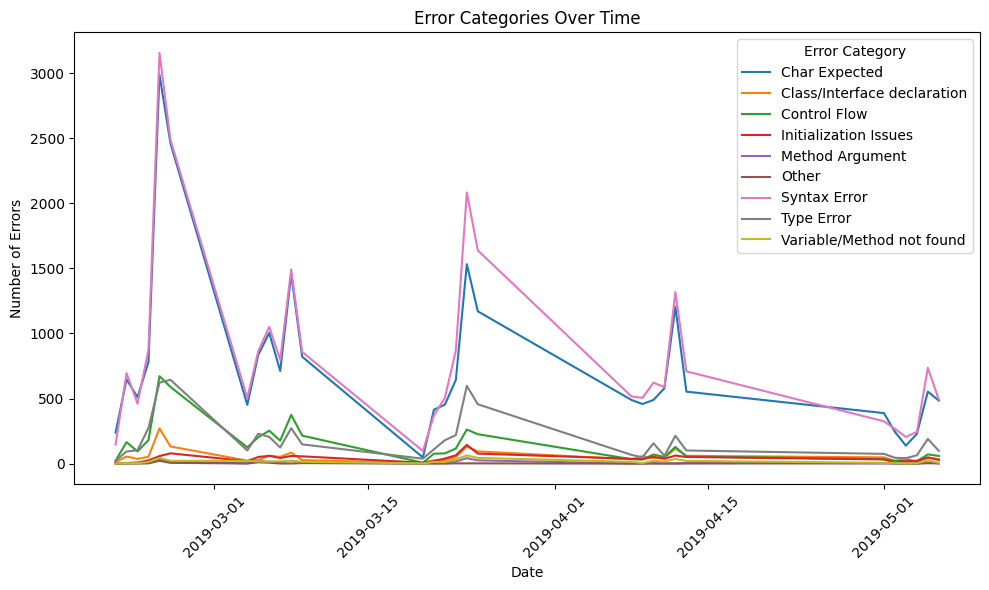

In [49]:
error_counts = messages.groupby(['Date', 'ErrorCategory']).size().unstack(fill_value=0)

# Plotting the line graph
plt.figure(figsize=(10, 6))
for category in error_counts.columns:
    plt.plot(error_counts.index, error_counts[category], label=category)

plt.xlabel('Date')
plt.ylabel('Number of Errors')
plt.title('Error Categories Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Error Category')
plt.tight_layout()
plt.show()

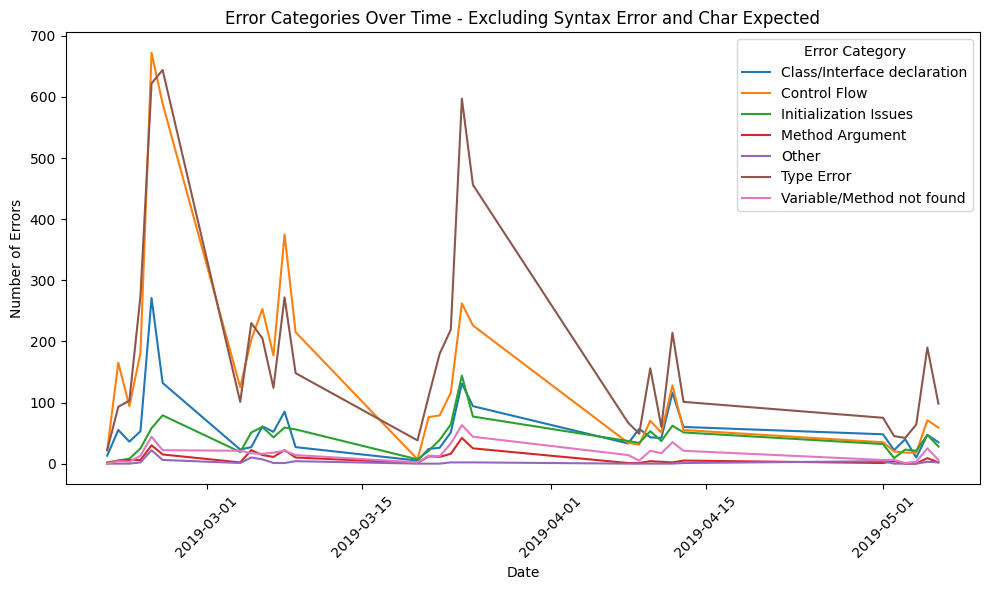

In [50]:
exclude_messages = messages[~messages['ErrorCategory'].isin(['Syntax Error', 'Char Expected'])]
error_counts_excluded = exclude_messages.groupby(['Date', 'ErrorCategory']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
for category in error_counts_excluded.columns:
    plt.plot(error_counts_excluded.index, error_counts_excluded[category], label=category)

plt.xlabel('Date')
plt.ylabel('Number of Errors')
plt.title('Error Categories Over Time - Excluding Syntax Error and Char Expected')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Error Category')
plt.tight_layout()
plt.show()